# Inspect SNN predictions

In [95]:
import pandas as pd

In [96]:
preds = pd.read_pickle('snndump/models/vanilla_S_0_CLF_2_R_none_photometry_DF_1.0_N_global_lstm_32x2_0.05_128_True_mean_C/PRED_vanilla_S_0_CLF_2_R_none_photometry_DF_1.0_N_global_lstm_32x2_0.05_128_True_mean_C.pickle')

Structure of preds file: 
- all_class0: complete light-curve classification, probability of being a SNe Ia. 
- all_class1: idem but fore not Ia probability
- PEAKMJD-2_class0: using only photometric points two days before maximum light classification, probability of being a SNe Ia. idem for "-1","","+1","+2" keys.
- target: true class used in SNN, as default 0=Ia
- all_random/shuffle/sin/reverse: out-of-distribution automatic tests. Mostly to be ignored.

In [97]:
preds.keys()

Index(['all_class0', 'all_class1', 'PEAKMJD-2_class0', 'PEAKMJD-2_class1',
       'PEAKMJD-1_class0', 'PEAKMJD-1_class1', 'PEAKMJD_class0',
       'PEAKMJD_class1', 'PEAKMJD+1_class0', 'PEAKMJD+1_class1',
       'PEAKMJD+2_class0', 'PEAKMJD+2_class1', 'all_random_class0',
       'all_random_class1', 'all_reverse_class0', 'all_reverse_class1',
       'all_shuffle_class0', 'all_shuffle_class1', 'all_sin_class0',
       'all_sin_class1', 'target', 'SNID'],
      dtype='object')

In [98]:
# Summary stats (given in terminal but verification)

In [99]:
# preds[[k for k in preds.keys() if "all_class" in k]].idxmax(axis=1)

In [100]:
from sklearn import metrics
import numpy as np
for time_key in ["PEAKMJD-2","PEAKMJD","PEAKMJD+2","all"]:
    preds[f"{time_key}_predicted_target"] = (
            preds[[k for k in preds.keys() if f"{time_key}_class" in k]]
            .idxmax(axis=1)
            .str.strip(f"{time_key}_class")
        )

Notes:
- if predicted_target is NaN means there is no photometry at that time constrain to get classification
- accuracy will give a warning when there is only type Ia as true tag

In [105]:
accuracy_dic = {}
for time_key in ["PEAKMJD-2","PEAKMJD","PEAKMJD+2","all"]:
    tmp = preds[preds[f"{time_key}_predicted_target"].notna()]
    accuracy_dic[time_key] = metrics.balanced_accuracy_score(tmp["target"].astype(int), tmp[f"{time_key}_predicted_target"].astype(int))

/Users/anaismoller/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [106]:
accuracy_dic

{'PEAKMJD': 0.9206896551724137,
 'PEAKMJD+2': 0.9216300940438872,
 'PEAKMJD-2': 0.9142857142857143,
 'all': 0.715531561461794}

Why early classification has better accuracy than late? probably due to the training set and also biased sampling for curves with points before max

Other useful metrics conputed only for full light-curve classification

In [107]:
SNe_Ia = preds[preds["target"].astype(int) == 0]
SNe_CC = preds[preds["target"].astype(int) != 0]
TP = len(SNe_Ia[SNe_Ia["all_predicted_target"].astype(int) == 0])
FP = len(SNe_CC[SNe_CC["all_predicted_target"].astype(int) == 0])

P = len(SNe_Ia)
N = len(SNe_CC)

efficiency = round(100.0 * TP / P, 2) if P > 0 else 0
print('Classification efficiency',efficiency)

Classification efficiency 71.55


# Understanding correlations with SNe Ia properties
to check correlations with c,x1 we need first to load the simualtion params

In [108]:
head = pd.read_csv("./test_sim_sncosmo/DAT_HEAD.csv")

In [109]:
preds['SNID']=preds['SNID'].astype(int) 
merged = pd.merge(preds,head,on='SNID')

this merged DataFrame contains both simulated properties and predictions by SNN

In [110]:
merged.keys()

Index(['all_class0', 'all_class1', 'PEAKMJD-2_class0', 'PEAKMJD-2_class1',
       'PEAKMJD-1_class0', 'PEAKMJD-1_class1', 'PEAKMJD_class0',
       'PEAKMJD_class1', 'PEAKMJD+1_class0', 'PEAKMJD+1_class1',
       'PEAKMJD+2_class0', 'PEAKMJD+2_class1', 'all_random_class0',
       'all_random_class1', 'all_reverse_class0', 'all_reverse_class1',
       'all_shuffle_class0', 'all_shuffle_class1', 'all_sin_class0',
       'all_sin_class1', 'target', 'SNID', 'PEAKMJD-2_predicted_target',
       'PEAKMJD_predicted_target', 'PEAKMJD+2_predicted_target',
       'all_predicted_target', 'Unnamed: 0', 'SIM_REDSHIFT_CMB', 'RA', 'DECL',
       'PEAKMJD', 'SIM_SALT2x1', 'SIM_SALT2c', 'SIM_PEAKMAG_b', 'SNTYPE'],
      dtype='object')

# Useful functions

In [111]:
def do_binning(df, var, bins, i):
    binned = df[(df[var] >= bins[i]) & (df[var] < bins[i + 1])]
    return binned

In [112]:
def bin_df(df,var="SIM_SALT2c",step=0.2):
    # Binning df by var with step 
    bin_dic = {}
    bin_dic["step"] = step
    bin_dic["min_var"] = df[var].min()
    bin_dic["max_var"] = df[var].max()
    bins = np.arange(bin_dic["min_var"], bin_dic["max_var"], bin_dic["step"])
    half_bin_step = bin_dic["step"] / 2.0
    bin_dic["bins_plot"] = np.arange(
        bin_dic["min_var"] + half_bin_step, bin_dic["max_var"] - half_bin_step, bin_dic["step"]
    )

    binned = {}
    for i, z_bin in enumerate(bins[:-1]):
        binned[round(bins[i]+half_bin_step,1)] = do_binning(df, var, bins, i)

    return binned

In [114]:
def get_accuracy(df,var_pred="all_predicted_target"):
    sel = df[df[var_pred].notna()] # in case there are no preds
    return metrics.balanced_accuracy_score(sel["target"].astype(int), sel[var_pred].astype(int))

In [89]:
import matplotlib.pyplot as plt

# complete classification

/Users/anaismoller/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


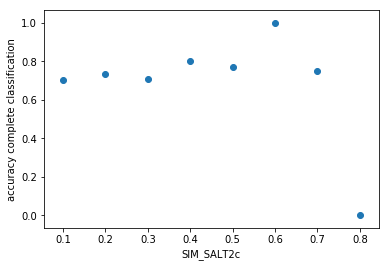

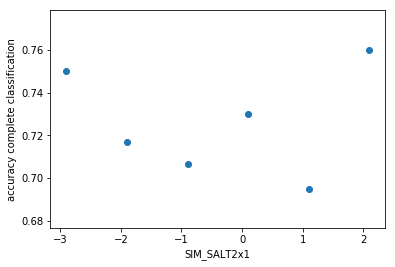

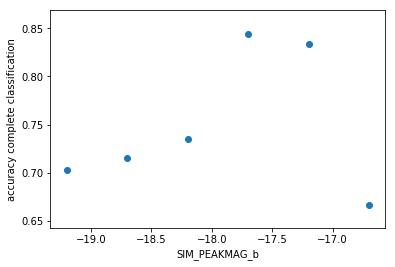

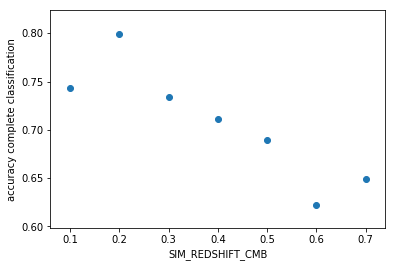

In [144]:
list_to_plot = ["SIM_SALT2c","SIM_SALT2x1","SIM_PEAKMAG_b",'SIM_REDSHIFT_CMB']
step_to_plot_dic = {"SIM_SALT2c":0.1,"SIM_SALT2x1":1,"SIM_PEAKMAG_b":0.5,'SIM_REDSHIFT_CMB':0.1}
for var_to_plot in list_to_plot:
    binned_c = bin_df(merged,var=var_to_plot,step=step_to_plot_dic[var_to_plot])
    binned_accuracy = {}
    for k in binned_c.keys():
        binned_accuracy[k] = get_accuracy(binned_c[k],var_pred="all_predicted_target")
    plt.figure()
    plt.scatter(list(binned_accuracy.keys()),list(binned_accuracy.values()))
    plt.xlabel(var_to_plot)
    plt.ylabel('accuracy complete classification')

# before max

/Users/anaismoller/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/Users/anaismoller/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/anaismoller/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


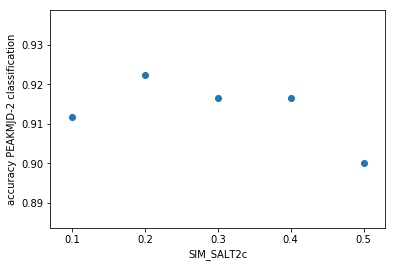

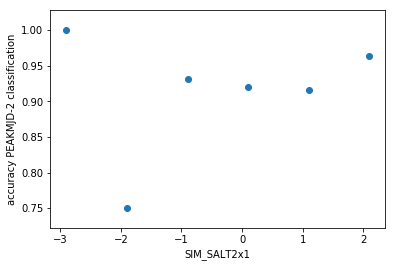

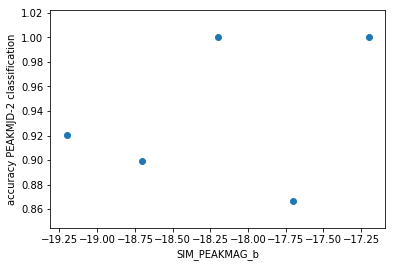

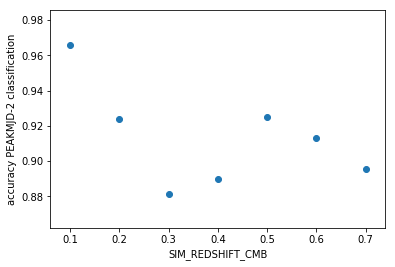

In [146]:
list_to_plot = ["SIM_SALT2c","SIM_SALT2x1","SIM_PEAKMAG_b",'SIM_REDSHIFT_CMB']
step_to_plot_dic = {"SIM_SALT2c":0.1,"SIM_SALT2x1":1,"SIM_PEAKMAG_b":0.5,'SIM_REDSHIFT_CMB':0.1}
for var_to_plot in list_to_plot:
    binned_c = bin_df(merged,var=var_to_plot,step=step_to_plot_dic[var_to_plot])
    binned_accuracy = {}
    for k in binned_c.keys():
        binned_accuracy[k] = get_accuracy(binned_c[k],var_pred="PEAKMJD-2_predicted_target")
    plt.figure()
    plt.scatter(list(binned_accuracy.keys()),list(binned_accuracy.values()))
    plt.xlabel(var_to_plot)
    plt.ylabel('accuracy PEAKMJD-2 classification')